# 3.6 softmax回归的从零开始实现

In [1]:
# 导入包或模块
import torch
import torchvision
import numpy as np
import sys
sys.path.append("..")  # 为了导入上层目录的d2lzh_pytorch
import d2lzh_pytorch as d2l

print(torch.__version__)
print(torchvision.__version__)

1.5.1
0.6.0a0+35d732a


## 3.6.1 获取和读取数据

In [2]:
# 设置批量大小为256
batch_size = 256
# 批量读取fashion_mnist数据集
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 3.6.2 初始化模型参数

In [3]:
# 每个图像形状为28*28，转换为向量，其长度为28*28=784
num_inputs = 784
# 图像有10个类，单层神经网络输出层的输出个数为10
num_outputs = 10

# softmax回归表达式为：O=X*W+b，Y^=softmax(O)
# 权重W形状为784*10
W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
# 偏差b形状为1*10
b = torch.zeros(num_outputs, dtype=torch.float)

In [4]:
# 显示模型参数梯度
print(W.requires_grad_(requires_grad=True))
print(b.requires_grad_(requires_grad=True))

tensor([[ 0.0248,  0.0061, -0.0085,  ...,  0.0071, -0.0037,  0.0128],
        [ 0.0023, -0.0005,  0.0031,  ..., -0.0021,  0.0191, -0.0032],
        [-0.0067,  0.0016, -0.0125,  ...,  0.0038, -0.0121,  0.0095],
        ...,
        [ 0.0052, -0.0029,  0.0103,  ..., -0.0018,  0.0236, -0.0127],
        [-0.0061,  0.0020, -0.0120,  ..., -0.0087, -0.0114,  0.0036],
        [-0.0137,  0.0081, -0.0089,  ...,  0.0177, -0.0111, -0.0156]],
       requires_grad=True)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


## 3.6.3 实现softmax运算

In [5]:
# 举例说明多维Tensor按维度操作
# 生成tensor时，圆括号里有2个方括号
X = torch.tensor([[1, 2, 3],
                  [4, 5, 6]])
# 根据结果领悟
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


In [6]:
# 定义softmax函数
def softmax(X):
    # X的行数是样本数，列数是输出个数
    # X的每个元素做指数运算
    X_exp = X.exp()
    # X的每行元素横向加和
    partition = X_exp.sum(dim=1, keepdim=True)
    # X的每个元素除以对应行元素之和
    return X_exp / partition

# 验证一下
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.1678, 0.2719, 0.2869, 0.1615, 0.1118],
        [0.1060, 0.2641, 0.2113, 0.2002, 0.2185]]) tensor([1., 1.])


## 3.6.4 定义模型

In [7]:
# 定义net函数
def net(X):
    # 通过view()将每张原始图像改成长度为num_inputs的向量
    # view()里面的-1表示，X的行数未知，列数给定，自适应修改X的形状
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

## 3.6.5 定义损失函数

In [8]:
y_hat = torch.tensor([[0.1, 0.3, 0.6],
                      [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
# gather(dim, index)，用法见官方手册
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [9]:
# 定义cross_entropy（）交叉熵损失函数
def cross_entropy(y_hat, y):
    # 这行代码没看明白
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

## 3.6.6 计算分类准确率

In [10]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [11]:
print(accuracy(y_hat, y))

0.5


In [12]:
# 评价模型net在数据集data_iter上的准确率
# 本函数已保存在d2lzh_pytorch包中方便以后使用
# 该函数将被逐步改进：它的完整实现将在“图像增广”一节中描述
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [13]:
print(evaluate_accuracy(test_iter, net))

0.0925


## 3.6.7 训练模型

In [20]:
num_epochs, lr = 10, 0.05

# 本函数已保存在d2lzh包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到
                
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
        
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.4154, train acc 0.858, test acc 0.837
epoch 2, loss 0.4148, train acc 0.858, test acc 0.840
epoch 3, loss 0.4143, train acc 0.858, test acc 0.842
epoch 4, loss 0.4135, train acc 0.859, test acc 0.840
epoch 5, loss 0.4127, train acc 0.859, test acc 0.840
epoch 6, loss 0.4121, train acc 0.860, test acc 0.842
epoch 7, loss 0.4113, train acc 0.860, test acc 0.839
epoch 8, loss 0.4108, train acc 0.860, test acc 0.841
epoch 9, loss 0.4102, train acc 0.860, test acc 0.839
epoch 10, loss 0.4094, train acc 0.860, test acc 0.841


## 3.6.8 预测

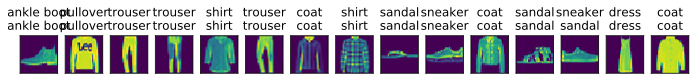

In [23]:
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:15], titles[0:15])